In [2]:
import mlflow
import dagshub
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlflow.models.signature import infer_signature
import pickle


In [13]:
dagshub.init(repo_owner='satyajeetrai007', repo_name='Youtube-Comment-Sentiment-Analysis', mlflow=True)

Initialized MLflow to track repo "satyajeetrai007/Youtube-Comment-Sentiment-Analysis"

Repository satyajeetrai007/Youtube-Comment-Sentiment-Analysis initialized!

In [3]:
import numpy as np
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [4]:
df.dropna(inplace=True)
df['clean_comment'] = df['clean_comment'].str.strip()
df.drop_duplicates(inplace=True)
df = df[~(df['clean_comment'].str.strip() == '')]
df.shape

(36607, 2)

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\satya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\satya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [8]:
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)

In [9]:
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [14]:
# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=5000)  
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category']  

In [15]:
# here created experiment with Name RF_Baseline
mlflow.set_experiment("RF Baseline")

<Experiment: artifact_location='mlflow-artifacts:/bba3fc28ff6f492ea196929a3c215dce', creation_time=1756065258120, experiment_id='1', last_update_time=1756065258120, lifecycle_stage='active', name='RF Baseline', tags={}>

🏃 View run RandomForest_Baseline_TrainTestSplit at: https://dagshub.com/satyajeetrai007/Youtube-Comment-Sentiment-Analysis.mlflow/#/experiments/1/runs/b36485a2d8cd4a2696ec53af2e36e5af
🧪 View experiment at: https://dagshub.com/satyajeetrai007/Youtube-Comment-Sentiment-Analysis.mlflow/#/experiments/1
Accuracy: 0.6459983611035236


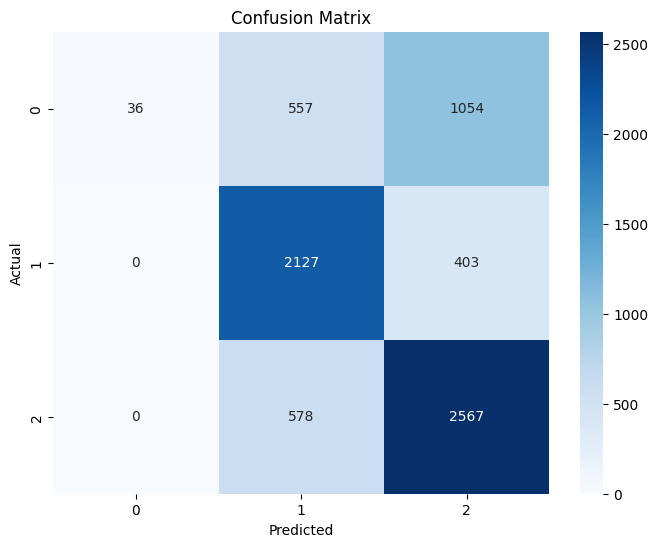

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

with mlflow.start_run() as run:
   
    mlflow.set_tag("author", "Satyajeet Rai")
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    n_estimators = 150
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    
    signature = infer_signature(X_train, model.predict(X_train))
    ###############################################################################################

    with open("model.pkl", "wb") as f:
        pickle.dump(model, f)

    # Load back (CI/CD reproducibility)
    with open("model.pkl", "rb") as f:
        clf = pickle.load(f)

  
    mlflow.log_artifact("model.pkl", "model")
        
    # Optionally log the dataset itself (if it's small enough)
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("dataset.csv")
    

# Display final accuracy
print(f"Accuracy: {accuracy}")

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.02      0.04      1647
           0       0.65      0.84      0.73      2530
           1       0.64      0.82      0.72      3145

    accuracy                           0.65      7322
   macro avg       0.76      0.56      0.50      7322
weighted avg       0.72      0.65      0.57      7322



In [3]:
df.to_csv('data_preprocessed.csv', index = False)

NameError: name 'df' is not defined